RNN - Erro dos pesos computados e usado somente durante a iteração

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import operator as op
import math
import time
from Utils99 import *
from CLOUD import *
from RLS_VDF import *
from RLS_LOG import *
from RLS_EXP import *
from Utils_graph import *
import optuna
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_pareto_front
from optuna.importance import get_param_importances
from optuna.samplers import RandomSampler
import sys
from TedaGraphs2 import *
import matplotlib.cm as cm
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
    
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm  # Certifique-se de importar cm

def plot_DSI3(teda, w=6, h=4, rect=[0, 0, 1, 1], out=None, title=None
              ,mergeID=True,lnwdth=0.75, ftcks=7, flbl=8, fttl=8.5, 
              flgnd=7, anchor=None, m1=3, m2=4, m3=1, ncol=1):
    
    x, y, qtd = teda.DSI1, teda.DSI2, len(teda.c)
    cmap = cm.get_cmap('tab20', qtd)  # 'tab20' pode gerar até 20 cores
    colors = [cmap(i / qtd) for i in range(qtd)]
    yticks = [i*0.2 for i in range(1,6)]+[0]
    merged_track = [(sorted(c.track, reverse=True)) for c in teda.c if len(c.track)>1]
    merged_track = [f'G{cloud[0]} = {cloud[1:]}' for cloud in merged_track]
    merged_track  = "; ".join(merged_track)
    if len(merged_track) == 0: merged_track = 'Merged Granules: None'
    else:
        merged_track = 'Merged Granules: ' + merged_track

    merged_clouds = []
    for cloud in teda.c:
        if len(cloud.track) > 1:
            merged_clouds.append(cloud.track)
    for i, array in enumerate(teda.cloud_activation):
        for ref in merged_clouds:
            if np.intersect1d(ref, array).size > 0:
                u = np.intersect1d(ref, array)
                u[:] = ref[0]
                teda.cloud_activation[i] = u

    clouds_ID = [cloud.ID for cloud in teda.c]
    names = [f'G{cloud_ID}' for cloud_ID in clouds_ID]
    xr, yr, tr = [[] for _ in range(qtd)], [[] for _ in range(qtd)], [[] for _ in range(qtd)]

    for i, cloud in enumerate(teda.cloud_activation):
        for j, cloud_ID in enumerate(clouds_ID):
            if cloud[-1] == cloud_ID:
                xr[j].append(x[i])
                yr[j].append(y[i])
                tr[j].append(i)

    fig, axes = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(w, h))
        
    
    # Plot do gráfico original à esquerda

    for i in range(len(xr)):
        axes['left'].plot(xr[i], yr[i], linestyle=' ', linewidth=lnwdth, marker='o'
                          , markersize=m1, label=names[i], color=colors[i])
        axes['left'].plot(teda.c[i].mean[0], teda.c[i].mean[1], linestyle=' '
                          , color='black', marker='x', markersize=m2)
        
        
        
    
    
    axes['left'].plot(teda.c[i].mean[0], teda.c[i].mean[1], linestyle=' '
                          , color='black', marker='x', markersize=m2, label = 'G centroid')
    
    #circle = Circle(teda.c[0].mean, teda.c[0].radius, fill=False, linewidth=lnwdth, color='black')
    #axes['left'].add_patch(circle)
    
    

    axes['left'].set_xlabel("DSI-X", fontsize=flbl)
    axes['left'].set_ylabel("DSI-Y", fontsize=flbl)
    #axes['left'].set_title(f'DSI - {name} (Left)', fontsize=fttl)
    axes['left'].legend(fontsize=flgnd, framealpha=0.85, bbox_to_anchor=anchor, ncol=ncol)
    axes['left'].grid()
    # Plot do gráfico empilhado à direita
    for i in range(len(xr)):
        # Subgráfico para "DSI-X"
        axes['upper right'].plot(tr[i], xr[i], linestyle=' ', marker='o', markersize=m1,
                                  label=None, color=colors[i])
        # Subgráfico para "DSI-Y"
        axes['lower right'].plot(tr[i], yr[i], linestyle=' ', marker='o', markersize=m1,
                                  label=None, color=colors[i])
    
    # Configuração do gráfico à direita (DSI-X)
    #axes['upper right'].set_xlabel("Cycle", fontsize=flbl)
    axes['upper right'].set_ylabel("DSI-X Value", fontsize=flbl)
    axes['upper right'].set_yticks(sorted(yticks))
    axes['upper right'].set_ylim(0, 1.1)
    axes['upper right'].grid()

    # Configuração do gráfico à direita (DSI-Y)
    axes['lower right'].set_xlabel("Cycle", fontsize=flbl)
    axes['lower right'].set_ylabel("DSI-Y Value", fontsize=flbl)
    axes['lower right'].set_yticks(sorted(yticks))
    axes['lower right'].set_ylim(0, 1.1)
    axes['lower right'].grid()
    
    #axes['upper right'].tick_params(labelbottom=True,labelsize=0,axis='x',length=0.1,)

    fig.suptitle(title)
    rect = [0,0.15,1,1]
    if mergeID: fig.text(0.5, 0.1, merged_track, fontsize=10, ha='center', va='bottom', transform=fig.transFigure)
    fig.tight_layout(rect=rect)

    if out is not None and title is not None:
        plt.savefig(out + 'DSI_' + title + '.png', dpi=500, transparent=False)

    plt.show()

/home/claudio/Área de trabalho/Python/Artigo_J3C/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
class DataCloud3:
	N=0
	def __init__(self,x,ID):
		self.ID = ID
		self.track = [ID]
		self.merged = False
		self.radius = 0
		self.n=1
		self.mean=x
		self.variance=0
		self.pertinency=1
	def addDataClaud(self,x):
		self.n=2
		self.mean=(self.mean+x)/2
		self.variance=((np.linalg.norm(self.mean-x))**2)
	def updateDataCloud(self,n,mean,variance):
		self.n=n
		self.mean=mean
		self.variance=variance

class AutoCloud3:
	def __init__(self, m):
			self.g = 1
			self.gCreated = 1
			self.c= np.array([DataCloud3(0,self.gCreated)],dtype=DataCloud3)
			self.alfa= np.array([0.0],dtype=float)
			self.intersection = np.zeros((1,1),dtype=int)
			self.listIntersection = np.zeros((1),dtype=int)
			self.matrixIntersection = np.zeros((1,1),dtype=int)
			self.relevanceList = np.zeros((1),dtype=int)
			self.classIndex = []
			self.k=1
			self.m = m
			self.cloud_activation = []

			self.DSI1 = np.array([])
			self.DSI2 = np.array([])
    		
	def mergeClouds(self):
		i=0
		while(i<len(self.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(self.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(self.listIntersection[i] == 1 and self.listIntersection[j] == 1):
					self.matrixIntersection[i,j] = self.matrixIntersection[i,j] + 1;
				trackI = self.c[i].track
				trackJ = self.c[j].track
				nI = self.c[i].n
				nJ = self.c[j].n
				meanI = self.c[i].mean
				meanJ = self.c[j].mean
				varianceI = self.c[i].variance
				varianceJ = self.c[j].variance
				nIntersc = self.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					merge = True
					self.gCreated = self.gCreated + 1
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud3(mean, self.gCreated)

					for id in trackI:
						newCloud.track.append(id)
					for id in trackJ:
						newCloud.track.append(id)

					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					self.listIntersection = np.concatenate((self.listIntersection[0 : i], np.array([1]), self.listIntersection[i + 1 : j],self.listIntersection[j + 1 : np.size(self.listIntersection)]),axis=None)
					#atualizando lista de data clouds 
					self.c = np.concatenate((self.c[0 : i ], np.array([newCloud]), self.c[i + 1 : j],self.c[j + 1 : np.size(self.c)]),axis=None)
					#update  intersection matrix
					M0 = self.matrixIntersection
					#Remover linhas 
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;   
					self.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1
				
	def run(self,X,transfer=False):
		#print(X)
		#print(self.gCreated)
		self.DSI1 = np.append(self.DSI1,X[0])
		self.DSI2 = np.append(self.DSI2,X[1])
		aux = np.array([])

		self.listIntersection = np.zeros((np.size(self.c)),dtype=int)
		if self.k==1 and not transfer:
			self.c[0]=DataCloud3(X,self.gCreated)
			aux = np.append(aux,1)

		elif self.k==2 and not transfer:
			self.c[0].addDataClaud(X)
			aux = np.append(aux,1)
		elif self.k>=3 or transfer:
			i=0
			createCloud = True
			self.alfa = np.zeros((np.size(self.c)),dtype=float)
			for cloud in self.c:
				n= cloud.n +1
				mean = ((n-1)/n)*cloud.mean + (1/n)*X
				variance = ((n-1)/n)*cloud.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(self.k-2)
				cloud.eccAn = eccentricity

				radius = (self.m**2 +1)/(2*n)

				if(norm_eccentricity<=(self.m**2 +1)/(2*n)):
					cloud.updateDataCloud(n,mean,variance)
					cloud.radius = radius
					self.alfa[i] = norm_typicality
					createCloud= False
					self.listIntersection.itemset(i,1)
					aux = np.append(aux,cloud.ID)
				else:
					self.alfa[i] = 0
					self.listIntersection.itemset(i,0)
				i+=1
			
			if(createCloud):
				self.gCreated = self.gCreated + 1
				self.c = np.append(self.c,DataCloud3(X,self.gCreated))
				self.listIntersection = np.insert(self.listIntersection,i,1)
				self.matrixIntersection = np.pad(self.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0)) 
				aux = np.append(aux,self.c[-1].ID)
			self.mergeClouds()
			
		self.k=self.k+1
		self.cloud_activation.append(aux)
			


Bearing1_3.csv


/tmp/ipykernel_49718/3368916972.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



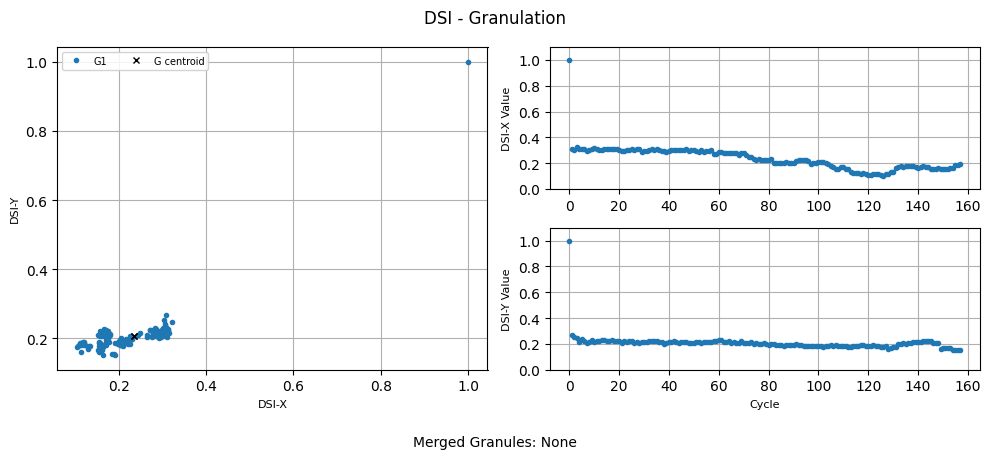

In [6]:
i=0
brngs = os.listdir('HI')
print(brngs[i])
RSX, RSY = 'RSX3/' + brngs[i], 'RSY3/' + brngs[i]
RSX, RSY = pd.read_csv(RSX), pd.read_csv(RSY)
RSX = RSX.iloc[:,i].values
RSY = RSY.iloc[:,i].values
#print(RSX[1],RSY[1])

dados = np.array([RSX,RSY])
dados= dados.T
teda=AutoCloud3(2)
for t in dados:
    teda.run(np.array(t))

plot_DSI3(teda,w=10,h=5,out=r'00_IMAGES/',title='DSI - Granulation',ncol=2)

In [7]:
custom = np.array(['Bearing1_1.csv', 'Bearing1_2.csv', 'Bearing1_3.csv'])
dir1, dir2 = r'RSX3/', r'RSY3/'
brngs= os.listdir(dir1)
m=0
RSXs, RSYs, RSXs1, RSYs1 = np.array([]), np.array([]), np.array([]), np.array([])
for brng in custom[:]:
    dfx, dfy = pd.read_csv(dir1+brng), pd.read_csv(dir2+brng)
    #dfx, dfy = exponential_moving_average_df(dfx,0.7), exponential_moving_average_df(dfy,0.7)
    RSX, RSY = dfx.iloc[:,m].values, dfy.iloc[:,m].values
    #RSX1, RSY1 = dfx.iloc[:,m+1].values, dfy.iloc[:,m+1].values

    RSXs = np.concatenate((RSXs,RSX[:]))
    RSYs = np.concatenate((RSYs,RSY[:]))
    #RSXs1 = np.concatenate((RSXs1,RSX1))
    #RSYs1 = np.concatenate((RSYs1,RSY1))


/tmp/ipykernel_49718/3368916972.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



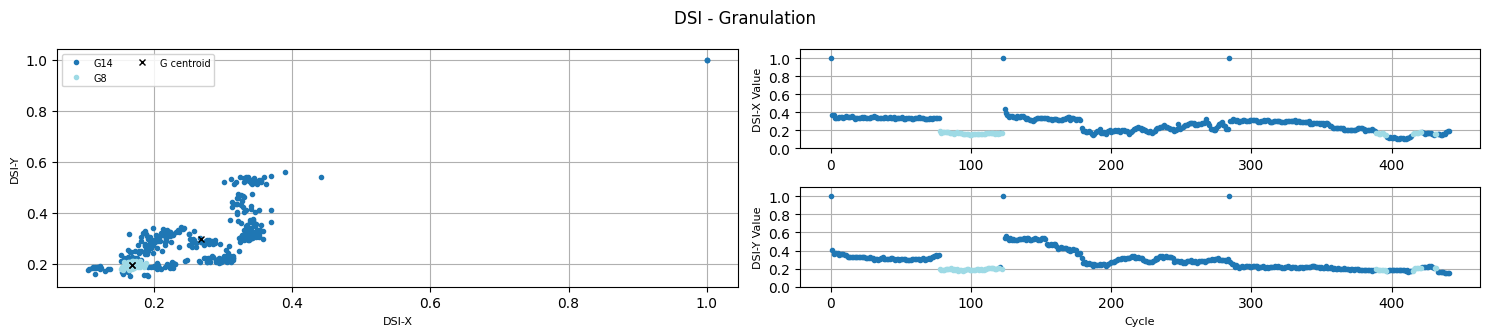

In [8]:
dados2 = np.array([RSXs[:],RSYs[:]])
dados2= dados2.T
teda2=AutoCloud3(1.9)
for t in dados2:
    teda2.run(np.array(t))

plot_DSI3(teda2,w=15,mergeID=False,title='DSI - Granulation',ncol=2)

In [47]:
custom = np.array(['Bearing1_1.csv', 'Bearing1_2.csv', 'Bearing1_3.csv', 'Bearing1_4.csv', 'Bearing1_5.csv'
                   , 'Bearing2_1.csv', 'Bearing2_2.csv', 'Bearing2_3.csv'])
d1, d2 = r'RSY3/', r'HIY2/'
brngs= os.listdir(dir1)
F1s, F2s = [], []
for brng in custom[:]:
    RS = pd.read_csv(d1+brng)
    RS = exponential_moving_average_df(RS,0.3)
    HI = pd.read_csv(d2+brng)
    F1, F2 = RS.iloc[:,1].values, HI.iloc[:,0].values
    F1s.append(F1[:])
    F2s.append(F2[:])

/tmp/ipykernel_49718/3368916972.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



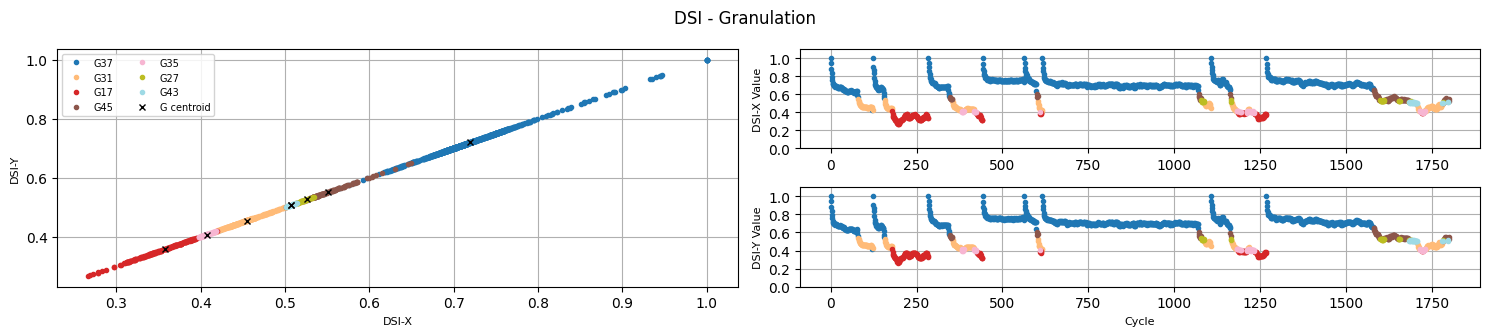

In [50]:
teda2=AutoCloud3(1.8)
transfer=False
for i in range(len(custom)):
    dados2 = np.array([F1s[i][:],F1s[i][:]])
    dados2= dados2.T
    for t in dados2:
        teda2.run(np.array(t),transfer)
    #for cloud in teda2.c:
        #print(cloud.n)
        #cloud.variance = 0.001
    if i>=0: 
        transfer=True
        teda2.k = 3
plot_DSI3(teda2,w=15,mergeID=False,title='DSI - Granulation',ncol=2)